In [1]:
from database import get_database_prod
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import timedelta

import matplotlib.pyplot as plt

In [2]:
def adjust_expiration(series):
    def adjust_single_expiration(date):
        mid_month = date.replace(day=15)
        weekday = mid_month.weekday()        
        if weekday < 5:
            return mid_month
        else:
            return mid_month - pd.Timedelta(days=(weekday - 4))

    return series.apply(adjust_single_expiration)

In [2]:
#get usda data from db
usda_collection = get_database_prod()["agri_data"]["wasde"]
usda_europe = usda_collection.find({
    "Region" : {"$in": ["World", "United States"]}
}).sort("ReleaseDate", -1)
usda_df = pd.DataFrame(list(usda_europe))

#perform transformation for manipulation
usda_df = usda_df.rename(columns={"ReleaseDate": "Date"})
usda_df["Date"] = pd.to_datetime(usda_df["Date"])
usda_df = usda_df[usda_df["Commodity"] == "Wheat"]

#same for stock to use needed values
usda_wheat_stckuse = usda_df[(usda_df["Attribute"].isin(["Domestic Total", "Exports", "Ending Stocks"])) & (usda_df["ReportTitle"] == "World Wheat Supply and Use")][["Date", "Region", "MarketYear", "Attribute", "Value", "ProjEstFlag"]].reset_index(drop=True)

#fill na values of proj est flag to current : pivot remove NaN values
usda_wheat_stckuse["ProjEstFlag"] = usda_wheat_stckuse["ProjEstFlag"].fillna("Curr.")

#pivot data and filter on region
usda_wheat_stckuse = usda_wheat_stckuse.pivot_table(index=['Date', 'Region', 'MarketYear', 'ProjEstFlag'], 
                           columns='Attribute', 
                           values='Value').reset_index()
us_wheat_stckuse = usda_wheat_stckuse[usda_wheat_stckuse["Region"] == "United States"]
world_wheat_stckuse = usda_wheat_stckuse[usda_wheat_stckuse["Region"] == "World"]

us_wheat_stckuse = us_wheat_stckuse.groupby("Date").last().reset_index()
world_wheat_stckuse = world_wheat_stckuse.groupby("Date").last().reset_index()

us_wheat_stckuse["StckUse"] = (us_wheat_stckuse["Ending Stocks"] / (us_wheat_stckuse["Domestic Total"] + us_wheat_stckuse["Exports"])) * 100
world_wheat_stckuse["StckUse"] = (world_wheat_stckuse["Ending Stocks"] / (world_wheat_stckuse["Domestic Total"] + world_wheat_stckuse["Exports"])) * 100

stck_to_use = pd.merge(us_wheat_stckuse, world_wheat_stckuse, on=["MarketYear", "Date"], how="inner")
stck_to_use = stck_to_use.rename(columns={
    "StckUse_x": "StckUse_US",
    "StckUse_y": "StckUse_World",
})
stck_to_use["Year-Month"] = stck_to_use["Date"].dt.to_period("M")
stck_to_use = stck_to_use[["Date", "StckUse_US", "StckUse_World", "Year-Month"]]

In [3]:
zw = pd.read_csv("dataset/ZWFutures.csv").drop("Unnamed: 0", axis=1)
zw["Date Time"] = pd.to_datetime(zw["Date Time"])
zw["Expiration"] = pd.to_datetime(zw["Expiration"])
zw = zw[zw["Date Time"] >= "1979-04-06"] #where we have more than one contract
zw["Expiration"] = adjust_expiration(zw["Expiration"])
zw.head()

,Date Time,Open,High,Low,Close,Change,Contract,Expiration
63,1979-04-06,344.25,345.0,344.25,345.0,1.0,ZWH80,1980-03-14
64,1979-04-06,349.00,349.5,349.00,349.0,0.0,ZWK80,1980-05-15
65,1979-04-09,345.00,345.0,344.00,344.5,-0.5,ZWH80,1980-03-14
66,1979-04-09,348.00,348.0,348.00,348.0,-1.0,ZWK80,1980-05-15
67,1979-04-10,343.25,346.0,342.50,346.0,1.5,ZWH80,1980-03-14


In [4]:
zw_monthly = zw.sort_values(["Date Time", "Expiration"]).groupby("Date Time").first()[["Close"]].resample("ME").mean().reset_index()

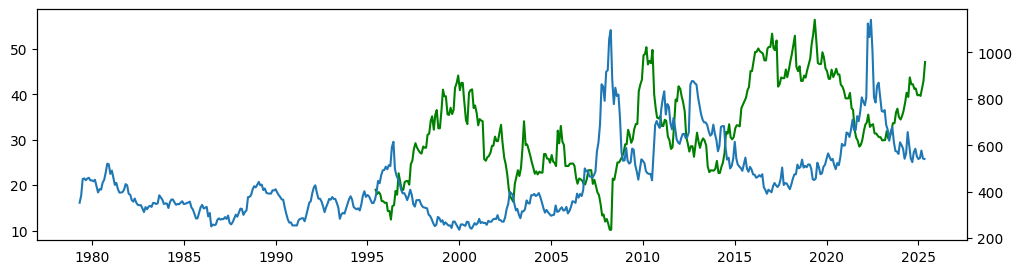

In [5]:
figure, ax1 = plt.subplots(figsize=(12,3))
ax1.plot(stck_to_use["Date"], stck_to_use["StckUse_US"], color="green")
ax2 = ax1.twinx()
ax2.plot(zw_monthly["Date Time"], zw_monthly["Close"])
plt.show()
plt.close("all")

In [ ]:
stck2007 = stck_to_use[stck_to_use["Date"] >= "2010-01-01"]
zw_monthly2007 = zw_monthly[zw_monthly["Date Time"] >= "2010-01-01"]

stck2007["Year-Month"] = stck2007["Date"].dt.to_period("M")
zw_monthly2007["Year-Month"] = zw_monthly2007["Date Time"].dt.to_period("M")

scat = pd.merge(stck2007[["Year-Month", "StckUse_US"]], zw_monthly2007[["Year-Month", "Close"]], on="Year-Month", how="inner")
scat["Date"] = pd.to_datetime(scat["Year-Month"].astype(str), format="%Y-%m")

R :  0.5694530317323645


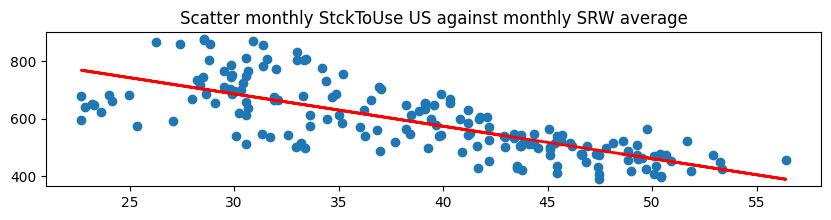

In [7]:
scat = scat[scat["Close"] < 1000] #remove russia invasion -> outsiders

x = scat[['StckUse_US']]
y = scat['Close']

model = LinearRegression()
reg = model.fit(x, y)
print("R : ", reg.score(x, y))

plt.figure(figsize=(10,2))
plt.scatter(scat["StckUse_US"], scat["Close"])
plt.plot(scat['StckUse_US'], model.predict(x), color='red', linewidth=2)
plt.title("Scatter monthly StckToUse US against monthly SRW average")
plt.show()
plt.close("all")

In [18]:
years = ["18","19","20","21", "23","24", "25"] #No 2022 cause of russia ukraine

In [ ]:
n = zw[zw["Contract"].str.contains("N")] #Where contract contains N
n["Year_Expiry"] = n["Contract"].str[-2:]

u = zw[zw["Contract"].str.contains("U")] #Where contract contains U
u["Year_Expiry"] = u["Contract"].str[-2:]

k = zw[zw["Contract"].str.contains("K")] #Where contract contains K
k["Year_Expiry"] = k["Contract"].str[-2:]

h = zw[zw["Contract"].str.contains("H")] #Where contract contains H
h["Year_Expiry"] = h["Contract"].str[-2:]
h["Year_Expiry_ZH"] = h["Contract"].str[-2:].astype(int) #new column that have the same year expiry with new name, for merging ZH spread

z = zw[zw["Contract"].str.contains("ZWZ")] #Where contract contains Z
z["Year_Expiry"] = z["Contract"].str[-2:]
z["Year_Expiry_ZH"] = z["Contract"].str[-2:].astype(int) + 1 # add one year on new column for merging ZH spread (year n Z, year n+1 h)


hk = pd.merge(h, k, on=["Date Time", "Year_Expiry"], how="inner") # merge on date and year expiry
hk["Spread"] = hk["Close_x"] - hk["Close_y"] #Spread calc
hk["Name"] = "HK" + hk["Year_Expiry"] #name of spread
hk = hk[["Date Time", "Name", "Spread", "Expiration_x"]].reset_index(drop=True)
hk["Days_Before_Expiry"] = (hk["Expiration_x"] - hk["Date Time"]).dt.days
hk_selected = hk[hk["Name"].str.contains('|'.join(years))].sort_values(by="Date Time").reset_index(drop=True) #keep only wanted years

hk_selected = hk_selected[hk_selected["Days_Before_Expiry"] <= 350] #keep only the 350 days before expiry

kn = pd.merge(k, n, on=["Date Time", "Year_Expiry"], how="inner") # merge on date and year expiry
kn["Spread"] = kn["Close_x"] - kn["Close_y"] #Spread calc
kn["Name"] = "KN" + kn["Year_Expiry"] #name of spread
kn = kn[["Date Time", "Name", "Spread", "Expiration_x"]].reset_index(drop=True)
kn["Days_Before_Expiry"] = (kn["Expiration_x"] - kn["Date Time"]).dt.days
kn_selected = kn[kn["Name"].str.contains('|'.join(years))].sort_values(by="Date Time").reset_index(drop=True) #keep only wanted years

kn_selected = kn_selected[kn_selected["Days_Before_Expiry"] <= 350] #keep only the 350 days before expiry

nu = pd.merge(n, u, on=["Date Time", "Year_Expiry"], how="inner") # merge on date and year expiry
nu["Spread"] = nu["Close_x"] - nu["Close_y"] #Spread calc
nu["Name"] = "NU" + nu["Year_Expiry"] #name of spread
nu = nu[["Date Time", "Name", "Spread", "Expiration_x"]].reset_index(drop=True)
nu["Days_Before_Expiry"] = (nu["Expiration_x"] - nu["Date Time"]).dt.days
nu_selected = nu[nu["Name"].str.contains('|'.join(years))].sort_values(by="Date Time").reset_index(drop=True) #keep only wanted years

nu_selected = nu_selected[nu_selected["Days_Before_Expiry"] <= 350] #keep only the 350 days before expiry

uz = pd.merge(u, z, on=["Date Time", "Year_Expiry"], how="inner") # merge on date and year expiry
uz["Spread"] = uz["Close_x"] - uz["Close_y"] #Spread calc
uz["Name"] = "UZ" + uz["Year_Expiry"] #name of spread
uz = uz[["Date Time", "Name", "Spread", "Expiration_x"]].reset_index(drop=True)
uz["Days_Before_Expiry"] = (uz["Expiration_x"] - uz["Date Time"]).dt.days
uz_selected = uz[uz["Name"].str.contains('|'.join(years))].sort_values(by="Date Time").reset_index(drop=True) #keep only wanted years

uz_selected = uz_selected[uz_selected["Days_Before_Expiry"] <= 350] #keep only the 350 days before expiry

zh = pd.merge(z, h, on=["Date Time", "Year_Expiry_ZH"], how="inner") # merge on date and year expiry
zh["Spread"] = zh["Close_x"] - zh["Close_y"] #Spread calc
zh["Name"] = "ZH" + zh["Year_Expiry_x"].astype(str) #name of spread
zh = zh[["Date Time", "Name", "Spread", "Expiration_x"]].reset_index(drop=True)
zh["Days_Before_Expiry"] = (zh["Expiration_x"] - zh["Date Time"]).dt.days
zh_selected = zh[zh["Name"].str.contains('|'.join(years))].sort_values(by="Date Time").reset_index(drop=True) #keep only wanted years

zh_selected = zh_selected[zh_selected["Days_Before_Expiry"] <= 350] #keep only the 350 days before expiry


In [20]:
hk_selected.head()

,Date Time,Name,Spread,Expiration_x,Days_Before_Expiry
610,2017-03-30,HK18,-9.75,2018-03-15,350
613,2017-03-31,HK18,-9.25,2018-03-15,349
614,2017-04-03,HK18,-9.25,2018-03-15,346
616,2017-04-04,HK18,-10.50,2018-03-15,345
618,2017-04-05,HK18,-11.00,2018-03-15,344


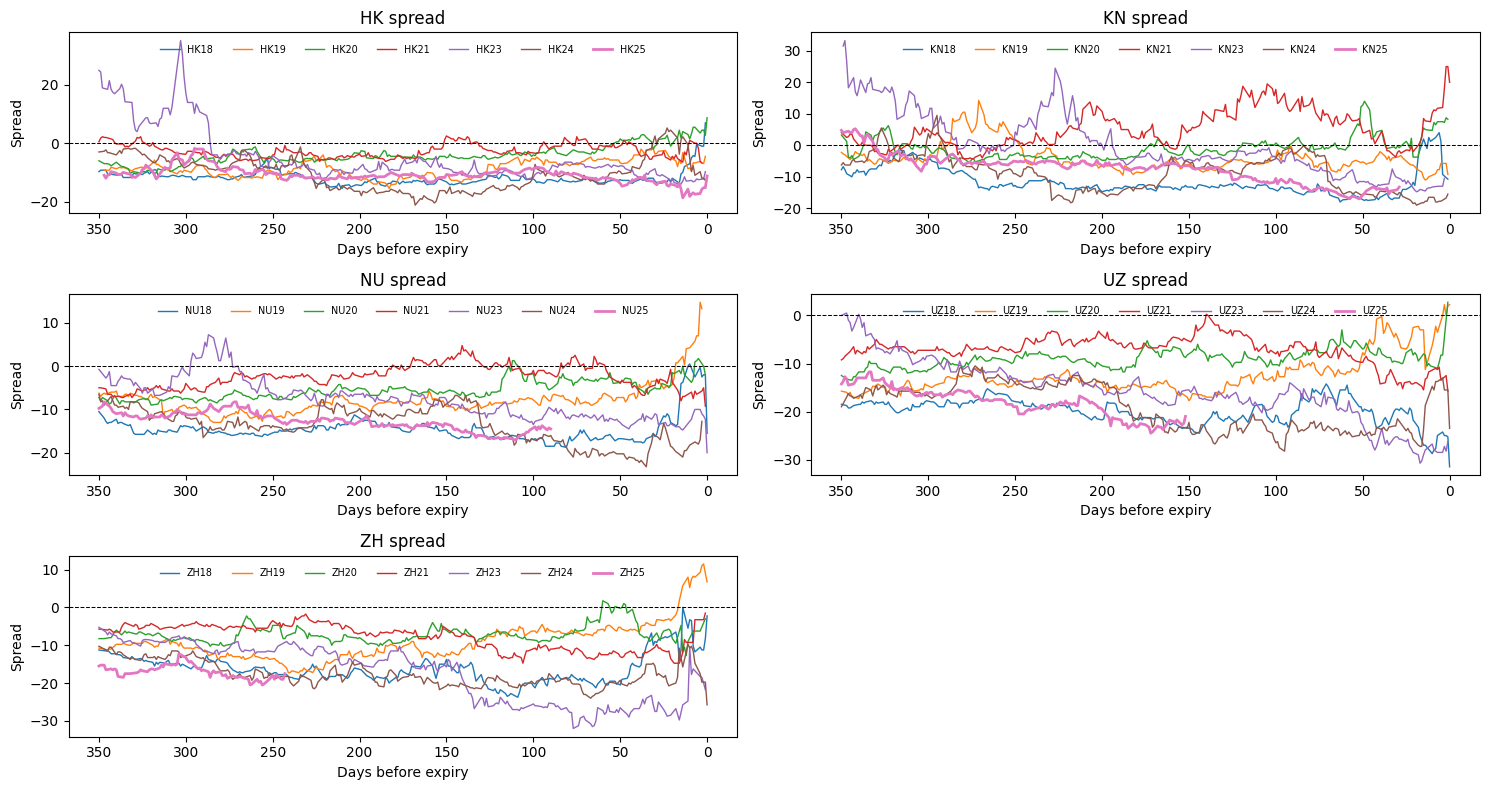

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(15, 8))

datasets = [
    (hk_selected, (0, 0)),
    (kn_selected, (0, 1)),
    (nu_selected, (1, 0)),
    (uz_selected, (1, 1)),
    (zh_selected, (2, 0))
]

for data, (i, j) in datasets:
    for ye in data["Name"].unique():
        linewidth = 1
        if years[-1] in ye:
            linewidth = 2
        subset = data[data["Name"] == ye]
        ax[i, j].plot(subset["Days_Before_Expiry"], subset["Spread"], label=ye, linewidth=linewidth)

    ax[i, j].xaxis.set_inverted(True)
    ax[i, j].axhline(y=0, color="black", linestyle="--", linewidth=0.75)
    ax[i, j].set_title(data["Name"].iloc[0][:2] + " spread")
    ax[i, j].set_xlabel('Days before expiry')
    ax[i, j].set_ylabel("Spread")
    ax[i, j].legend(fontsize="x-small", markerscale=0.5, ncol=len(data["Name"].unique()), loc="upper center", bbox_to_anchor=(0.5, 0.980), frameon=False)
fig.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

In [25]:
imp_exp = pd.read_csv("dataset/FAOSTAT_data_en_5-26-2025.csv")
top10_export = imp_exp[(imp_exp["Year"] == 2023) & (imp_exp["Element"] == "Export quantity")].nlargest(10, 'Value')[["Area", "Year", "Value", "Unit"]]
top10_export["Total Percentage"] = top10_export["Value"] / imp_exp[(imp_exp["Year"] == 2023) & (imp_exp["Element"] == "Export quantity")]["Value"].sum() * 100
print(f"Top 10 exporters accounts for {top10_export['Total Percentage'].sum()} of world exports in 2023")
top10_export

Top 10 exporters accounts for 81.93791857674718 of world exports in 2023


,Area,Year,Value,Unit,Total Percentage
13827,Russian Federation,2023,31599103.87,t,15.868543
741,Australia,2023,29292037.83,t,14.709973
2954,Canada,2023,25571108.57,t,12.841384
17396,United States of America,2023,17942310.41,t,9.010329
16895,Ukraine,2023,16151704.85,t,8.111117
6192,France,2023,13476663.17,t,6.767755
13764,Romania,2023,8171216.09,t,4.103448
8804,Kazakhstan,2023,7202625.71,t,3.617038
13208,Poland,2023,6972401.02,t,3.501423
6573,Germany,2023,6784192.03,t,3.406908


In [9]:
us_wheat_stckuse

Attribute,Date,Region,MarketYear,ProjEstFlag,Domestic Total,Ending Stocks,Exports,StckUse
0,1995-06-12,United States,1995/96,Curr.,33.01,12.48,32.66,19.004111
1,1995-07-12,United States,1995/96,Curr.,33.20,11.66,31.30,18.077519
2,1995-08-14,United States,1995/96,Curr.,33.20,12.05,31.98,18.487266
3,1995-09-12,United States,1995/96,Curr.,32.52,11.63,31.98,18.031008
4,1995-10-11,United States,1995/96,Curr.,32.52,10.75,32.66,16.492789
...,...,...,...,...,...,...,...,...
353,2025-01-10,United States,2024/25,Proj.,31.30,21.71,23.13,39.886092
354,2025-02-11,United States,2024/25,Proj.,31.39,21.62,23.13,39.655172
355,2025-03-11,United States,2024/25,Proj.,31.39,22.30,22.73,41.204730
356,2025-04-10,United States,2024/25,Proj.,31.34,23.03,22.32,42.918375


<BarContainer object of 12 artists>

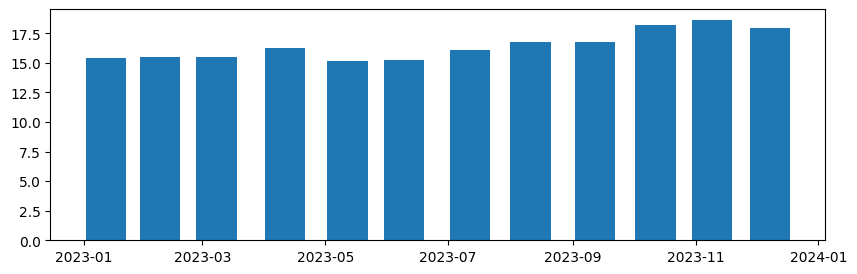

In [21]:
plt.figure(figsize=(10,3))
plt.bar(us_wheat_stckuse[(us_wheat_stckuse["Date"] >= "2023-01-01") & (us_wheat_stckuse["Date"] <= "2023-12-31")]["Date"],
         us_wheat_stckuse[(us_wheat_stckuse["Date"] >= "2023-01-01") & (us_wheat_stckuse["Date"] <= "2023-12-31")]["Ending Stocks"],
         width=20)